In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics import JaccardIndex
import matplotlib.pyplot as plt
import seaborn as sns

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Checkpoint, ExperimentAnalysis
import tempfile

from dataset.uavid_dataset import UAVidDataset
from losses.focal_loss import PixelwiseFocalLoss
from utils.visualizations import visualize_inference, plot_best_trial_metrics

from transformers import SegformerForSemanticSegmentation

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.cuda.empty_cache()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-01 12:09:28,455	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-12-01 12:09:28,687	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
START_TRAINING = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
mapping = {
    (0, 0, 0): 0,
    (128, 128, 0): 1,
    (128, 64, 128): 2,
    (128, 0, 0): 3,
    (64, 64, 0): 4,
    (64, 0, 128): 5,
    (0, 128, 0): 6,
    (192, 0, 192): 7
}

reversed_mapping = {v: k for k, v in mapping.items()}

data_path = os.path.abspath('/teamspace/studios/this_studio/uavid-semantic-segmentation/uavid_dataset/')

In [5]:
def load_data(root_dir, train_transforms, valid_transforms, mapping, config):
    train_dataset = UAVidDataset(root_dir=root_dir, data_part='train', class_mapping=mapping, transforms=train_transforms)
    valid_dataset = UAVidDataset(root_dir=root_dir, data_part='valid', class_mapping=mapping, transforms=valid_transforms)

    train_loader = DataLoader(
        train_dataset, 
        batch_size=int(config["batch_size"]), 
        shuffle=True, 
        num_workers=4,
        pin_memory=True, 
        persistent_workers=True
    )
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=int(config["batch_size"]), 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True, 
        persistent_workers=True
    )

    return train_loader, valid_loader

In [6]:
def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, device: torch.device, jaccard: JaccardIndex, accumulation_steps: int):
    model.train()
    total_loss = 0
    total_iou = 0
    
    optimizer.zero_grad()

    for i, (data, target) in enumerate(train_loader):
        data = data.float().to(device, non_blocking=True)
        target = target.long().to(device, non_blocking=True)
               
        outputs = model(data)
        logits = outputs.logits
        logits = F.interpolate(logits, size=target.shape[-2:], mode='bilinear', align_corners=False)
        loss = F.cross_entropy(logits, target) / accumulation_steps
        
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
 
        total_loss += loss.item() * accumulation_steps
        
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            iou = jaccard(pred, target)
            total_iou += iou.item()
        
        del data, target, outputs, logits, pred, loss
        
    if (i + 1) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    return total_loss / len(train_loader), total_iou / len(train_loader)


def valid_epoch(model: nn.Module, valid_loader: DataLoader, criterion: nn.Module, device: torch.device, jaccard: JaccardIndex):
    model.eval()
    total_loss = 0
    total_iou = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data = data.float().to(device, non_blocking=True)
            target = target.long().to(device, non_blocking=True)

            outputs = model(data)
            logits = outputs.logits
            logits = F.interpolate(logits, size=target.shape[-2:], mode='bilinear', align_corners=False)
            loss = F.cross_entropy(logits, target)
            
            total_loss += loss.item()

            pred = logits.argmax(dim=1)
            iou = jaccard(pred, target)
            total_iou += iou.item()
            
            del data, target, outputs, logits, pred, loss

    return total_loss / len(valid_loader), total_iou / len(valid_loader)

def evaluate(model: nn.Module, loader: DataLoader, device: torch.device, is_test: bool = False):
    model.eval()
    predictions = []
    targets = []
    image_paths = []

    with torch.no_grad():
        for batch in loader:
            if is_test:
                data, paths = batch
                data = data.float().to(device, non_blocking=True)
                outputs = model(data)

                logits = outputs.logits
                logits = F.interpolate(logits, size=target.shape[-2:], mode='bilinear', align_corners=False)
            
                pred = logits.argmax(dim=1)

                predictions.append(pred.cpu())
            else:
                data, target = batch
                data = data.float().to(device, non_blocking=True)
                target = target.long().to(device, non_blocking=True)
                
                outputs = model(data)

                logits = outputs.logits
                logits = F.interpolate(logits, size=target.shape[-2:], mode='bilinear', align_corners=False)
            
                pred = logits.argmax(dim=1)
                
                predictions.append(pred.cpu())
                targets.append(target.cpu())
            
            del data, outputs, logits, pred

    predictions = torch.cat(predictions, dim=0)
    
    if is_test:
        return predictions, image_paths
    else:
        targets = torch.cat(targets, dim=0)
        return predictions, targets

In [7]:
def train_segformer(config, data_dir=None):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

    train_transforms_local = A.Compose([
        A.HorizontalFlip(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.25),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.25),
        A.GaussianBlur(blur_limit=(3, 5), p=0.25),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(540, 960),
        ToTensorV2(transpose_mask=True)
    ])

    valid_transforms_local = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(540, 960),
        ToTensorV2(transpose_mask=True)
    ])

    mapping_local = {
        (0, 0, 0): 0,
        (128, 128, 0): 1,
        (128, 64, 128): 2,
        (128, 0, 0): 3,
        (64, 64, 0): 4,
        (64, 0, 128): 5,
        (0, 128, 0): 6,
        (192, 0, 192): 7
    }

    train_loader, valid_loader = load_data(
        data_dir,
        train_transforms=train_transforms_local,
        valid_transforms=valid_transforms_local,
        mapping=mapping_local,
        config=config
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class_counts = torch.zeros(8)
    sample_batches = min(5, len(train_loader))
    for i, (_, masks) in enumerate(train_loader):
        if i >= sample_batches:
            break
        unique, counts = torch.unique(masks.flatten(), return_counts=True)
        for class_id, count in zip(unique, counts):
            class_counts[class_id] += count

    total = class_counts.sum()
    weights_local = total / (8 * class_counts.float())
    weights_local = torch.clamp(weights_local, max=50.0)

    num_classes = 8
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )

    for param in model.parameters():
        param.requires_grad = False
    for param in model.decode_head.parameters():
        param.requires_grad = True

    model.to(device)

    criterion = PixelwiseFocalLoss(alpha=weights_local.to(device))
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    epochs = config.get('epochs', 20)

    jaccard = JaccardIndex(task='multiclass', num_classes=8).to(device)

    for epoch in range(epochs):
        try:
            train_loss, train_iou = train_epoch(
                model, train_loader, criterion, optimizer, device,
                jaccard, accumulation_steps=config.get('accumulation_steps', 4)
            )
            val_loss, val_iou = valid_epoch(model, valid_loader, criterion, device, jaccard)

            scheduler.step(val_loss)

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                checkpoint_path = os.path.join(temp_checkpoint_dir, "checkpoint.pth")
                torch.save(model.state_dict(), checkpoint_path)

                tune.report(
                    {"loss": val_loss, "iou": val_iou, "train_loss": train_loss, "train_iou": train_iou},
                    checkpoint=Checkpoint.from_directory(temp_checkpoint_dir)
                )
        except torch.cuda.OutOfMemoryError as e:
            print(f"OOM Error in epoch {epoch}: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            raise e

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [8]:
if START_TRAINING:
    segformer_config = {
        "lr": tune.loguniform(1e-4, 1e-1),
        "weight_decay": tune.loguniform(1e-6, 1e-2),
        "batch_size": tune.choice([8, 16]),
        "accumulation_steps": tune.choice([8]),
        "epochs": 20
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=20,
        grace_period=2,
        reduction_factor=2
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_segformer, data_dir=data_path),
            resources={"cpu": 4, "gpu": 0.5} 
        ),
        param_space=segformer_config,
        tune_config=tune.TuneConfig(
            scheduler=scheduler,
            num_samples=10
        )
    )

    segformer_results = tuner.fit()

    best_result_segformer = segformer_results.get_best_result(metric="loss", mode="min")
    print(f"\nBest trial config: {best_result_segformer.config}")
    print(f"Best trial final validation IoU: {best_result_segformer.metrics['iou']:.4f}")
    print(f"Best trial final validation loss: {best_result_segformer.metrics['loss']:.4f}")

In [9]:
checkpoint_dir = None

try:
    best_result_segformer = segformer_results.get_best_result(metric="loss", mode="min")
    best_checkpoint = best_result_segformer.checkpoint
    with best_checkpoint.as_directory() as checkpoint_dir_path:
        checkpoint_path = os.path.join(checkpoint_dir_path, "checkpoint.pth")
        checkpoint_dir = "/".join(checkpoint_dir_path.split("/")[:-1])
except NameError:
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_')]
    if checkpoint_files:
        latest_checkpoint = sorted(checkpoint_files)[-1]
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint, "checkpoint.pth")
    else:
        checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 8
model_segformer = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

for param in model_segformer.parameters():
    param.requires_grad = False
for param in model_segformer.decode_head.parameters():
    param.requires_grad = True

model_segformer.load_state_dict(torch.load(checkpoint_path, map_location=device))
model_segformer.to(device)
model_segformer.eval()

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([8]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([8, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [10]:
dataset = UAVidDataset(
    root_dir=data_path, 
    data_part='valid', 
    class_mapping=mapping, 
    transforms=A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(540, 960),
        ToTensorV2(transpose_mask=True)
    ])
)

loader = DataLoader(
    dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True, 
    persistent_workers=True
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


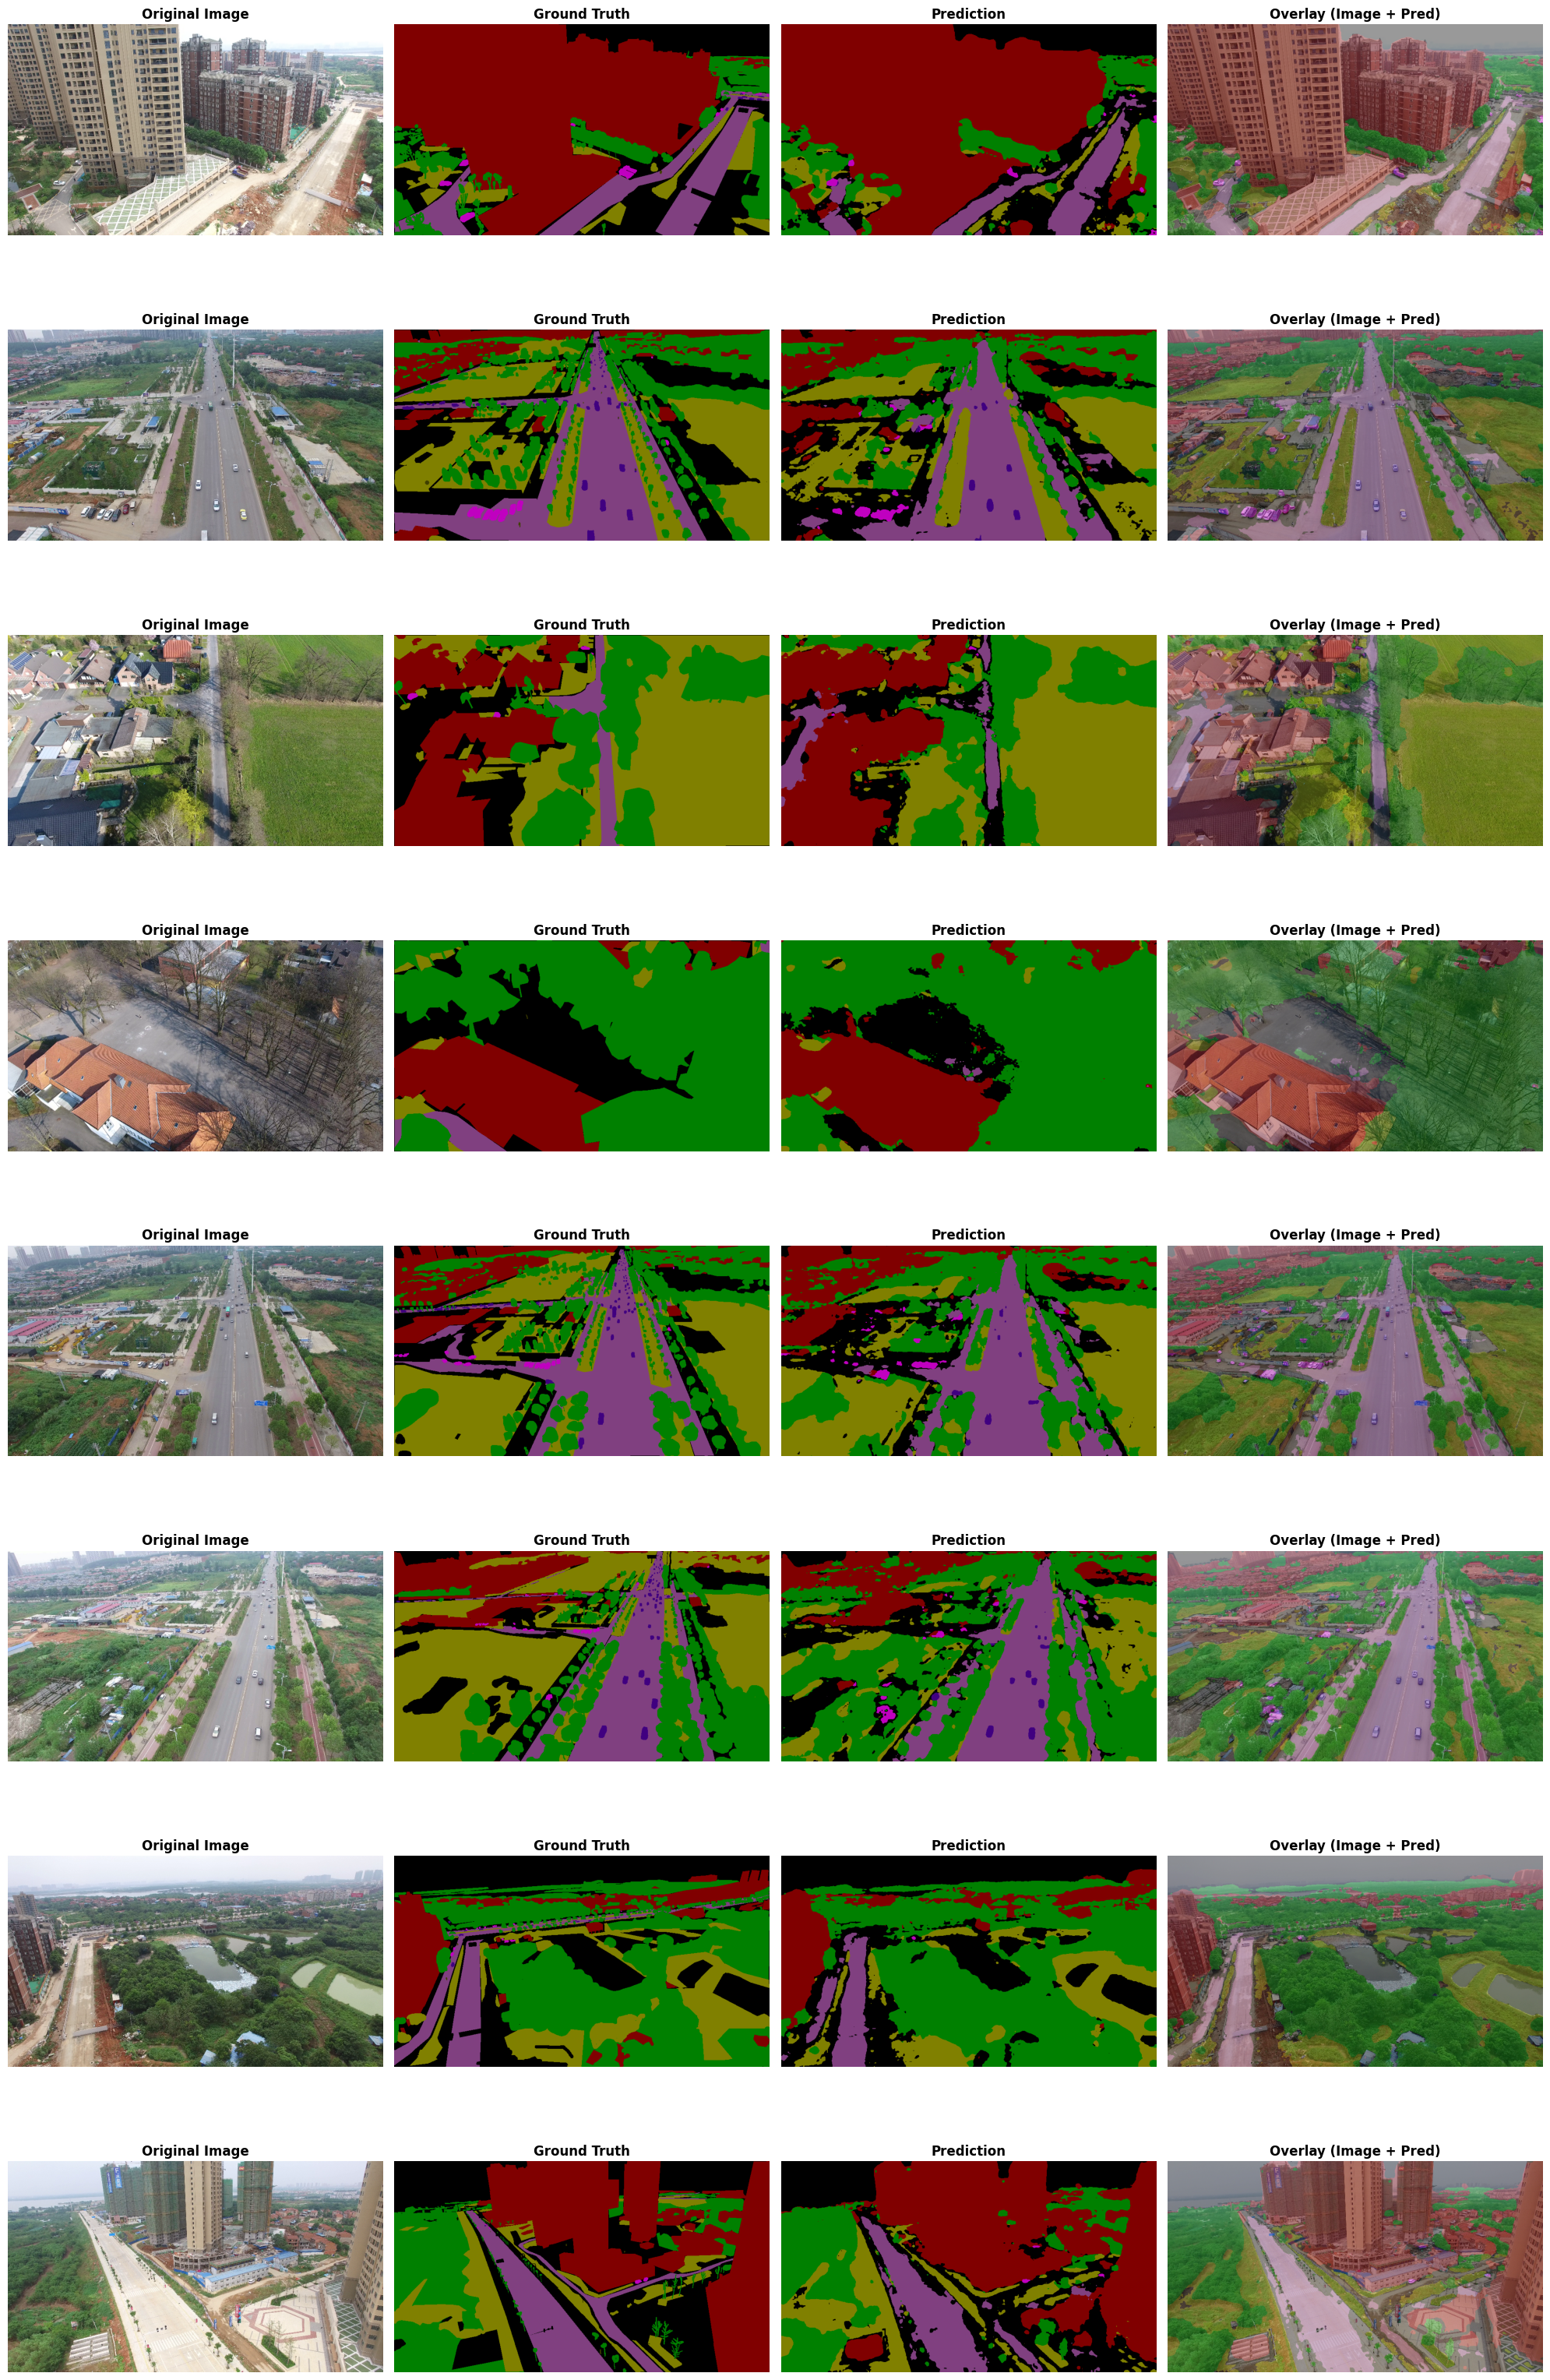

In [11]:
visualize_inference(
    model=model_segformer,
    dataloader=loader,
    device=device,
    reversed_mapping=reversed_mapping,
    num_samples=8
)

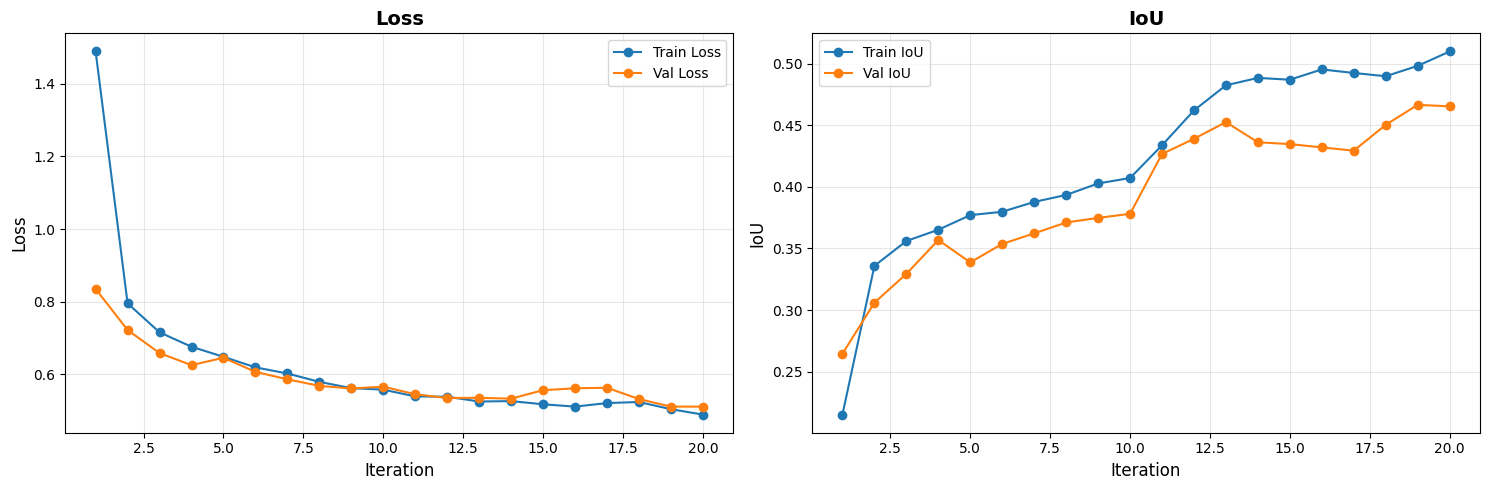

In [12]:
plot_best_trial_metrics(
    f"{checkpoint_dir}/progress.csv"
)

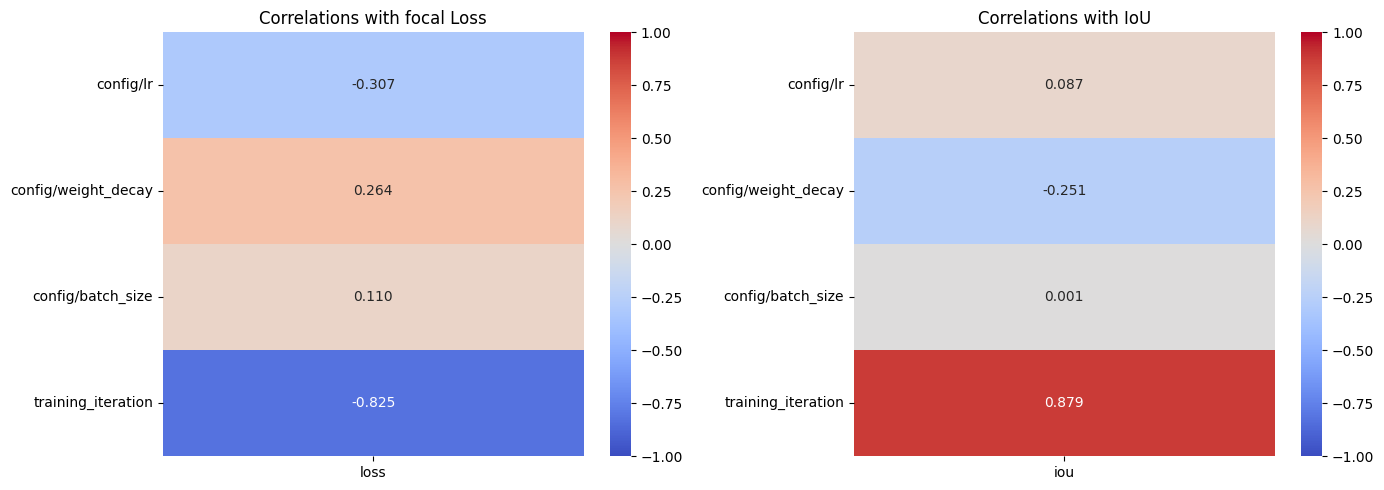

In [15]:
analysis = ExperimentAnalysis("/".join(checkpoint_dir.split("/")[:-1]))

results_df = analysis.dataframe()

param_cols = ['config/lr', 'config/weight_decay', 'config/batch_size', 'training_iteration']

results_clean = results_df[param_cols + ['loss', 'iou']].dropna()

results_clean['config/batch_size'] = results_clean['config/batch_size'].astype(float)
corr_matrix = results_clean.corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(corr_matrix[['loss']].iloc[:-2], annot=True, fmt='.3f', cmap='coolwarm', ax=axes[0], vmin=-1, vmax=1, center=0)
axes[0].set_title('Correlations with focal Loss')

sns.heatmap(corr_matrix[['iou']].iloc[:-2], annot=True, fmt='.3f', cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1, center=0)
axes[1].set_title('Correlations with IoU')

plt.tight_layout()
plt.show()

SegFormer achieved the best results among AlexNetFCN, U-Net, DeepLabV3, and SegFormer, which aligns with expectations given its transformer-based architecture. This advantage likely stems from its hierarchical encoder capturing multi-scale features more effectively and its lightweight MLP decoder efficiently fusing representations without the computational overhead.